# This notebook reconstructs buffers to create additional data
## Ethnologue data cannot be shared freely due to copyright issues

# Setup

In [1]:
#%%px --local
#!/usr/bin/env python
# coding: utf-8
'''
======================================================
Author:  Ömer Özak, 2014 (ozak at smu.edu)
Website: http://omerozak.com
GitHub:  https://github.com/ozak/
======================================================
Construct Fishnet of size X
'''
from __future__ import division
# Parallel
#try:
#    from ipyparallel import Client
#except:
#    from IPython.parallel import Client

## Setup the clients, direct views, and balanced views
#c = Client()
#c.ids
#dview = c[:]
#view = c.load_balanced_view()
#dview.activate()

import sys, os, time
import matplotlib.pyplot as plt
# Math, data
import numpy as np
import pandas as pd
pd.set_option('display.width', 140)

#import pandas.tools.util as tools
# GIS packages
os.environ['USE_PYGEOS'] = '0'
#from osgeo import  ogr, osr, gdal, gdalnumeric
#from gdalconst import *
#from PIL import Image, ImageDraw
#from pyGDsandbox.dataIO import df2dbf, dbf2df
#from rasterstats import zonal_stats
#import shutil, glob
#import pysal as ps
#from pysal.contrib import shapely_ext
#import shapely
from shapely.geometry import Polygon, Point
#from shapely.wkt import loads, dumps
#from shapely.ops import cascaded_union
import pyproj
import georasters as gr
#import hmi
import fiona
import fiona.crs
import geopandas as gp
import geopandas.tools as gpt
gpd = gp
import dask_geopandas
#from geopandas.tools import sjoin
#from geopy.distance import great_circle
#import geostats

from pyproj import CRS
cea = CRS("ESRI:54034")
wgs84 = CRS("EPSG:4326")

# File packages
#import tarfile
#import gzip

# Graph packages
#import skimage.graph as graph
#from skimage.morphology import watershed
#import networkx as nx

# Econometrics
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from patsy import dmatrices

# Various other packages
#from rtree import index     # Indices
#import difflib              # Match text
import isounidecode         # Decode and encode text
#from collections import OrderedDict
import itertools
from functools import reduce

# Paths
path = './'
proot = '../../data/'
pathout = proot + 'Ethnologue/'
pathethno = '' # Since the Ethnologed is protected under copy rights we can't upload the dataset.
pathdickens = proot + '../Dickens-EJ-2021/ueab065_replication_files/'
pathstats = proot + 'stats/'
pathgraphs = '../../graphs/'

if not os.path.exists(pathout):
    os.mkdir(pathout)

if not os.path.exists(pathstats):
    os.mkdir(pathstats)

if not os.path.exists(pathgraphs):
    os.mkdir(pathgraphs)

/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for detai

In [2]:
# Plotting
import matplotlib as mpl
import seaborn as sns
# Setup seaborn
sns.set()

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

In [3]:
#%%px --local
def Borders(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.type.isin(["LineString", "MultiLineString"])
        intersections.loc[poly_ix] = intersections[poly_ix]#.buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gpd.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        return gpd.GeoDataFrame(
            [],
            columns=list(set(df1.columns).union(df2.columns)) + ["__idx1", "__idx2"],
            crs=df1.crs,
        )
    
def _overlay_intersection(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.geom_type.isin(["Polygon", "MultiPolygon"])
        intersections.loc[poly_ix] = intersections[poly_ix].buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gp.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        result = df1.iloc[:0].merge(
            df2.iloc[:0].drop(df2.geometry.name, axis=1),
            left_index=True,
            right_index=True,
            suffixes=("_1", "_2"),
        )
        result["__idx1"] = None
        result["__idx2"] = None
        return result[
            result.columns.drop(df1.geometry.name).tolist() + [df1.geometry.name]
        ]

In [4]:
# Drop repeated pairs
def drop_repeated(df, cols):
    df1 = df[cols].copy()
    df1['reps'] = df1.apply(lambda x: list(set(x[cols].astype(str))), axis=1)
    df1['reps'] = df1.reps.apply(lambda x: '-'.join(x))
    df1 = df1.drop_duplicates('reps')
    df1 = df1.drop('reps', axis=1).reset_index(drop=True)
    return df1

## Set up the buffer size **RADIUS** in Kilometer in the cell below (The default is 50km radius)

In [5]:
buffer_size_radius_km = 50

<div class="alert alert-block alert-info", >
    <center><H1>Using Original Data</H1>
</div>

# Import original replication files provided with paper
* We import only shapefiles to show construction and difference/similarity. 
* We import only the file for the 50km buffer (i.e., the 100km diameter)

## Main original replication data file with all pairwise data based on buffers of 50kms

In [6]:
dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')
dfor

/tmp/ipykernel_2042158/3197352363.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')


,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
1,AAA-NGA-OKE-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Okpe,oke,Nigeria,Niger-Congo,0.628569,...,oke,aaa,oke,GHOTUO,OKPE,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
2,AAB-NGA-JID-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Bu,jid,Nigeria,Niger-Congo,0.833333,...,jid,aab,jid,TESU,BU_NIGERIA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
3,AAB-NGA-RIN-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Nungu,rin,Nigeria,Niger-Congo,NaN,...,rin,aab,rin,TESU,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
4,AAB-NGA-TDV-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Toro,tdv,Nigeria,Niger-Congo,0.532142,...,tdv,aab,tdv,TESU,TORO,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15598,ZYN-CHN-YUE-CHN,"Zhuang, Yongnan",zyn,China,Tai-Kadai,"Chinese, Yue",yue,China,Sino-Tibetan,0.813015,...,yue,zyn,yue,NINGMING_YONGNAN_ZHUANG,CANTONESE,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15599,ZZJ-CHN-CMN-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,"Chinese, Mandarin",cmn,China,Sino-Tibetan,0.865388,...,cmn,zzj,cmn,LONGZHOU_ZHUANG,KUNMING_MANDARIN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15600,ZZJ-CHN-IUM-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Iu Mien,ium,China,Hmong-Mien,0.844456,...,ium,zzj,ium,LONGZHOU_ZHUANG,CHIANGRAI_MIEN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Hmong-Mien,Mienic,Mian-Jin",156.0,156.0,Asia
15601,ZZJ-CHN-TYZ-VNM,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Tay,tyz,Vietnam,Tai-Kadai,0.528902,...,tyz,zzj,tyz,LONGZHOU_ZHUANG,TAY,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central",156.0,704.0,Asia


In [7]:
dfor.loc[dfor.identifier=='SPA-MEX-SPA-GTM']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [8]:
dfor.loc[dfor.identifier=='SPA-GTM-SPA-MEX']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [9]:
dfor.loc[dfor.identifier=='AAA-NGA-EMA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa


In [10]:
dfor.loc[dfor.identifier=='EMA-NGA-AAA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


## Pairs in original dataset that are the same language but in two countries

In [11]:
dfor.loc[dfor.identifier.apply(lambda x: x[:3]==x[8:11])]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
78,ABR-CIV-ABR-GHA,Abron,abr,Cote d'Ivoire,Niger-Congo,Abron,abr,Ghana,Niger-Congo,NaN,...,abr,abr,abr,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Nyo...","Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Nyo...",384.0,288.0,Africa
164,ADQ-TGO-ADQ-GHA,Adangbe,adq,Togo,Niger-Congo,Adangbe,adq,Ghana,Niger-Congo,NaN,...,adq,adq,adq,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Lef...","Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Lef...",768.0,288.0,Africa
376,AII-TUR-AII-SYR,Assyrian Neo-Aramaic,aii,Turkey,Afro-Asiatic,Assyrian Neo-Aramaic,aii,Syria,Afro-Asiatic,NaN,...,aii,aii,aii,ASSYRIAN_NEO-ARAMAIC,ASSYRIAN_NEO-ARAMAIC,"Afro-Asiatic,Semitic,Central,Aramaic,Eastern,C...","Afro-Asiatic,Semitic,Central,Aramaic,Eastern,C...",792.0,760.0,Asia
407,AJG-TGO-AJG-BEN,Aja,ajg,Togo,Niger-Congo,Aja,ajg,Benin,Niger-Congo,NaN,...,ajg,ajg,ajg,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Lef...","Niger-Congo,Atlantic-Congo,Volta-Congo,Kwa,Lef...",768.0,204.0,Africa
713,ARS-IRQ-ARS-SAU,"Arabic, Najdi Spoken",ars,Iraq,Afro-Asiatic,"Arabic, Najdi Spoken",ars,Saudi Arabia,Afro-Asiatic,NaN,...,ars,ars,ars,missing,missing,"Afro-Asiatic,Semitic,Central,South,Arabic","Afro-Asiatic,Semitic,Central,South,Arabic",368.0,682.0,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15002,YBL-CMR-YBL-NGA,Yukuben,ybl,Cameroon,Niger-Congo,Yukuben,ybl,Nigeria,Niger-Congo,NaN,...,ybl,ybl,ybl,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",120.0,566.0,Africa
15112,YKO-GNQ-YKO-CMR,Yasa,yko,Equatorial Guinea,Niger-Congo,Yasa,yko,Cameroon,Niger-Congo,NaN,...,yko,yko,yko,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",226.0,120.0,Africa
15140,YMK-MOZ-YMK-TZA,Maraba,ymk,Mozambique,Niger-Congo,Maraba,ymk,Tanzania,Niger-Congo,NaN,...,ymk,ymk,ymk,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",508.0,834.0,Africa
15159,YOM-AGO-YOM-COD,Yombe,yom,Angola,Niger-Congo,Yombe,yom,Democratic Republic of Congo,Niger-Congo,NaN,...,yom,yom,yom,missing,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",24.0,180.0,Africa


In [12]:
dfor.loc[dfor.identifier.apply(lambda x: x[:3]==x[8:11]), ['identifier', 'lingDist']]

,identifier,lingDist
78,ABR-CIV-ABR-GHA,NaN
164,ADQ-TGO-ADQ-GHA,NaN
376,AII-TUR-AII-SYR,NaN
407,AJG-TGO-AJG-BEN,NaN
713,ARS-IRQ-ARS-SAU,NaN
...,...,...
15002,YBL-CMR-YBL-NGA,NaN
15112,YKO-GNQ-YKO-CMR,NaN
15140,YMK-MOZ-YMK-TZA,NaN
15159,YOM-AGO-YOM-COD,NaN


# Shapefiles for figure 1, which shows the buffer construction

In [13]:
africa_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Africa_Country_Borders.shp')
border_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Border.shp')
manyika_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Manyika.shp')
shona_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Shona.shp')
buffer_or = gp.read_file(pathdickens + 'ShapeFiles/Fig1/Shona_Manyika_Buffer.shp')

## Verify which CRS they have

In [14]:
africa_or.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
border_or.crs

<Projected CRS: ESRI:54052>
Name: World_Goode_Homolosine_Land
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Interrupted Goode Homolosine
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
manyika_or.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [17]:
shona_or.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [18]:
buffer_or.crs

<Projected CRS: ESRI:54052>
Name: World_Goode_Homolosine_Land
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Interrupted Goode Homolosine
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Concatenate both ethnic groups for plotting

<Axes: >

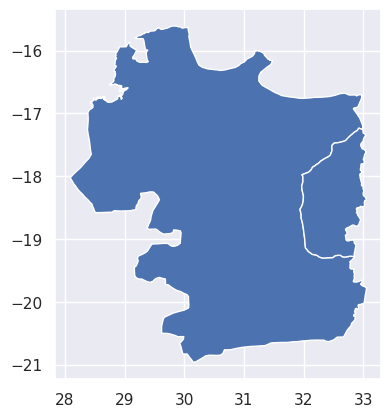

In [19]:
ethn_or = pd.concat([shona_or, manyika_or])
ethn_or.plot()

## Reproject everything to same projection

In [20]:
buffer_or['NAM_LABEL'] = 'Buffer zone (100 km)'
border_or['NAM_LABEL'] = 'Shona-Mankiya Border'

In [21]:
buffer_or_wgs84 = buffer_or.to_crs(shona_or.crs) 
border_or_wgs84 = border_or.to_crs(shona_or.crs) 

In [22]:
border_or_wgs84_buf = border_or_wgs84.copy()
border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)

/tmp/ipykernel_2042158/3197058390.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  border_or_wgs84_buf.geometry = border_or_wgs84_buf.geometry.buffer(0.01)


## Replicate Figure 1 
### No code provided for comparison, we do not know the underlying projection
### Basic map, we do not make nice legend

In [23]:
extent = pd.DataFrame([ethn_or.total_bounds,
                       buffer_or_wgs84.total_bounds,
                       border_or_wgs84.total_bounds,
                      ], columns=['xmin', 'ymin', 'xmax', 'ymax'])
xmin = extent['xmin'].min() - 1
ymin = extent['ymin'].min() - 1
xmax = extent['xmax'].max() + 1
ymax = extent['ymax'].max() + 1
extent = [xmin, ymin, xmax, ymax]

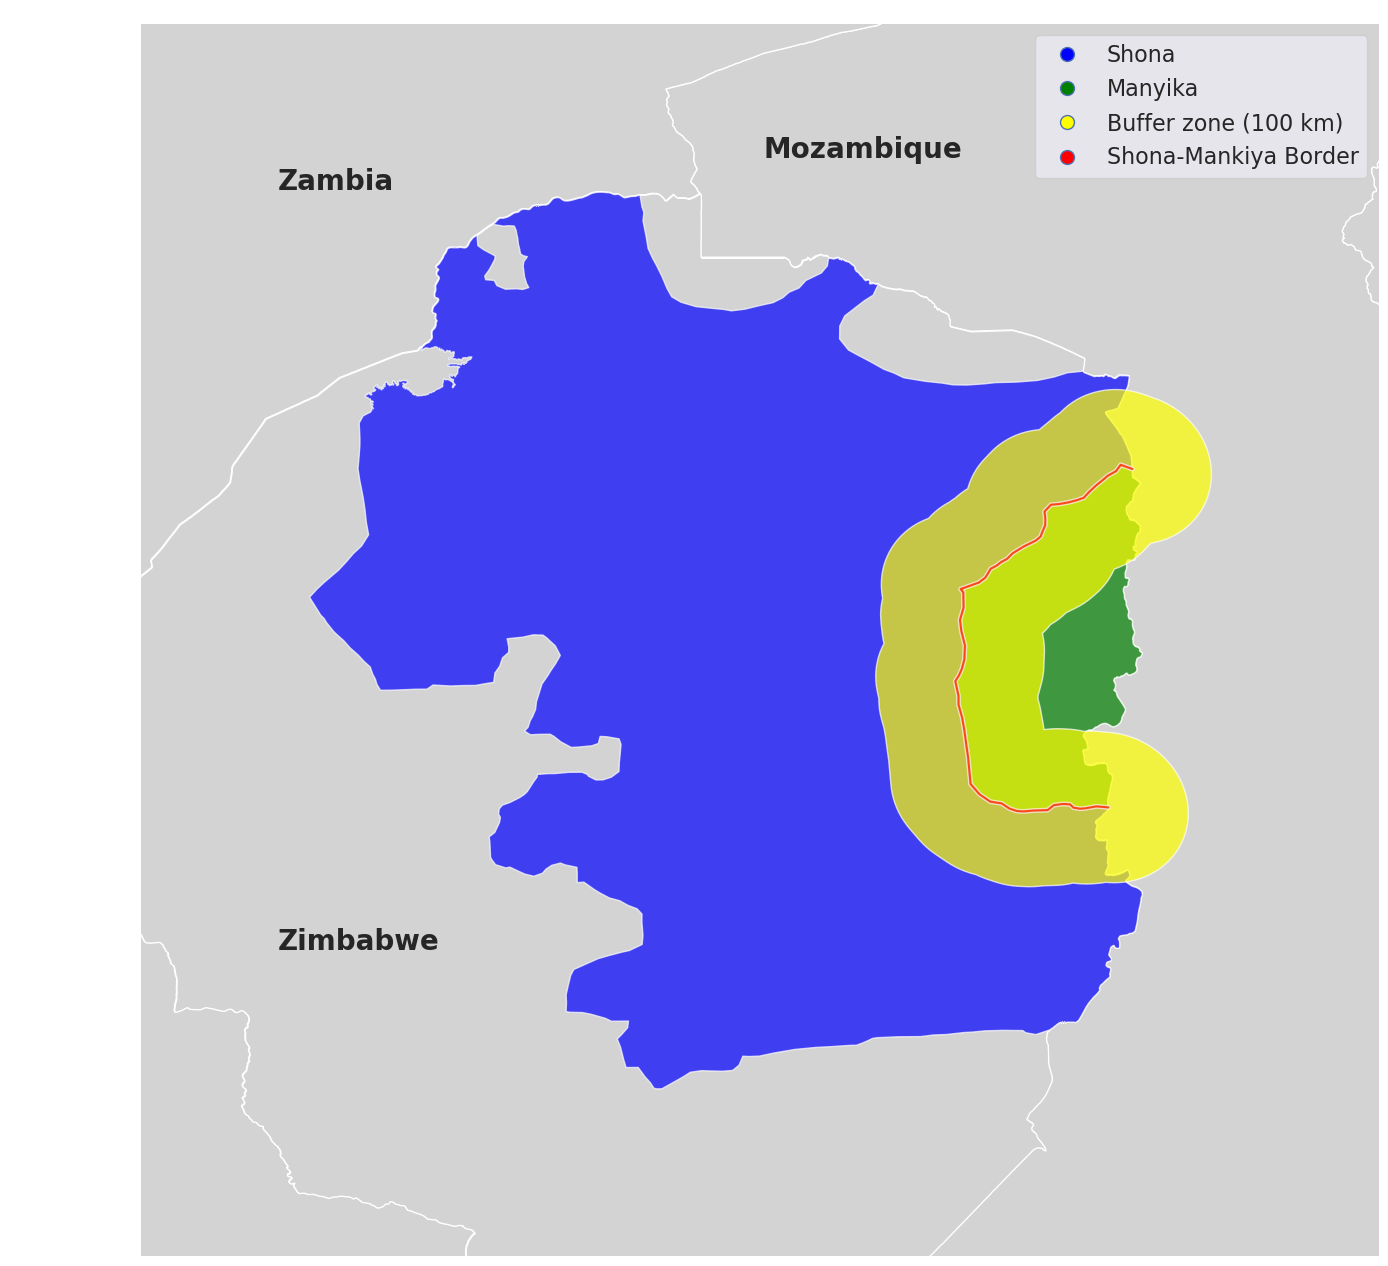

In [24]:
cmap = mpl.colors.ListedColormap(['blue', 'green', 'yellow', 'red'])
dfmap = pd.concat([ethn_or, buffer_or_wgs84, border_or_wgs84_buf]).reset_index()

# Retrieve unique labels
labels = dfmap['NAM_LABEL'].unique()

# Create categorical data type
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=labels, ordered=True)

# Convert 'NAM_LABEL' column to categorical
dfmap['NAM_LABEL_fac'] = dfmap['NAM_LABEL'].astype(cat_type).cat.codes

ax = gplt.choropleth(
        dfmap, hue='NAM_LABEL_fac',
        projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=None, linewidth=1, 
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap,
        figsize=(24, 16),
        scheme = mc.UserDefined(dfmap['NAM_LABEL_fac'], bins=dfmap['NAM_LABEL_fac'].tolist()),
        legend_labels=dfmap['NAM_LABEL'].tolist(),
        rasterized=True,
        alpha=0.7#[[0.5, 1, 1, 1]]
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
plt.savefig(pathgraphs + 'figure-1-original-data.pdf', dpi=300, bbox_inches='tight')

Text(0.55, 0.875, 'Mozambique')

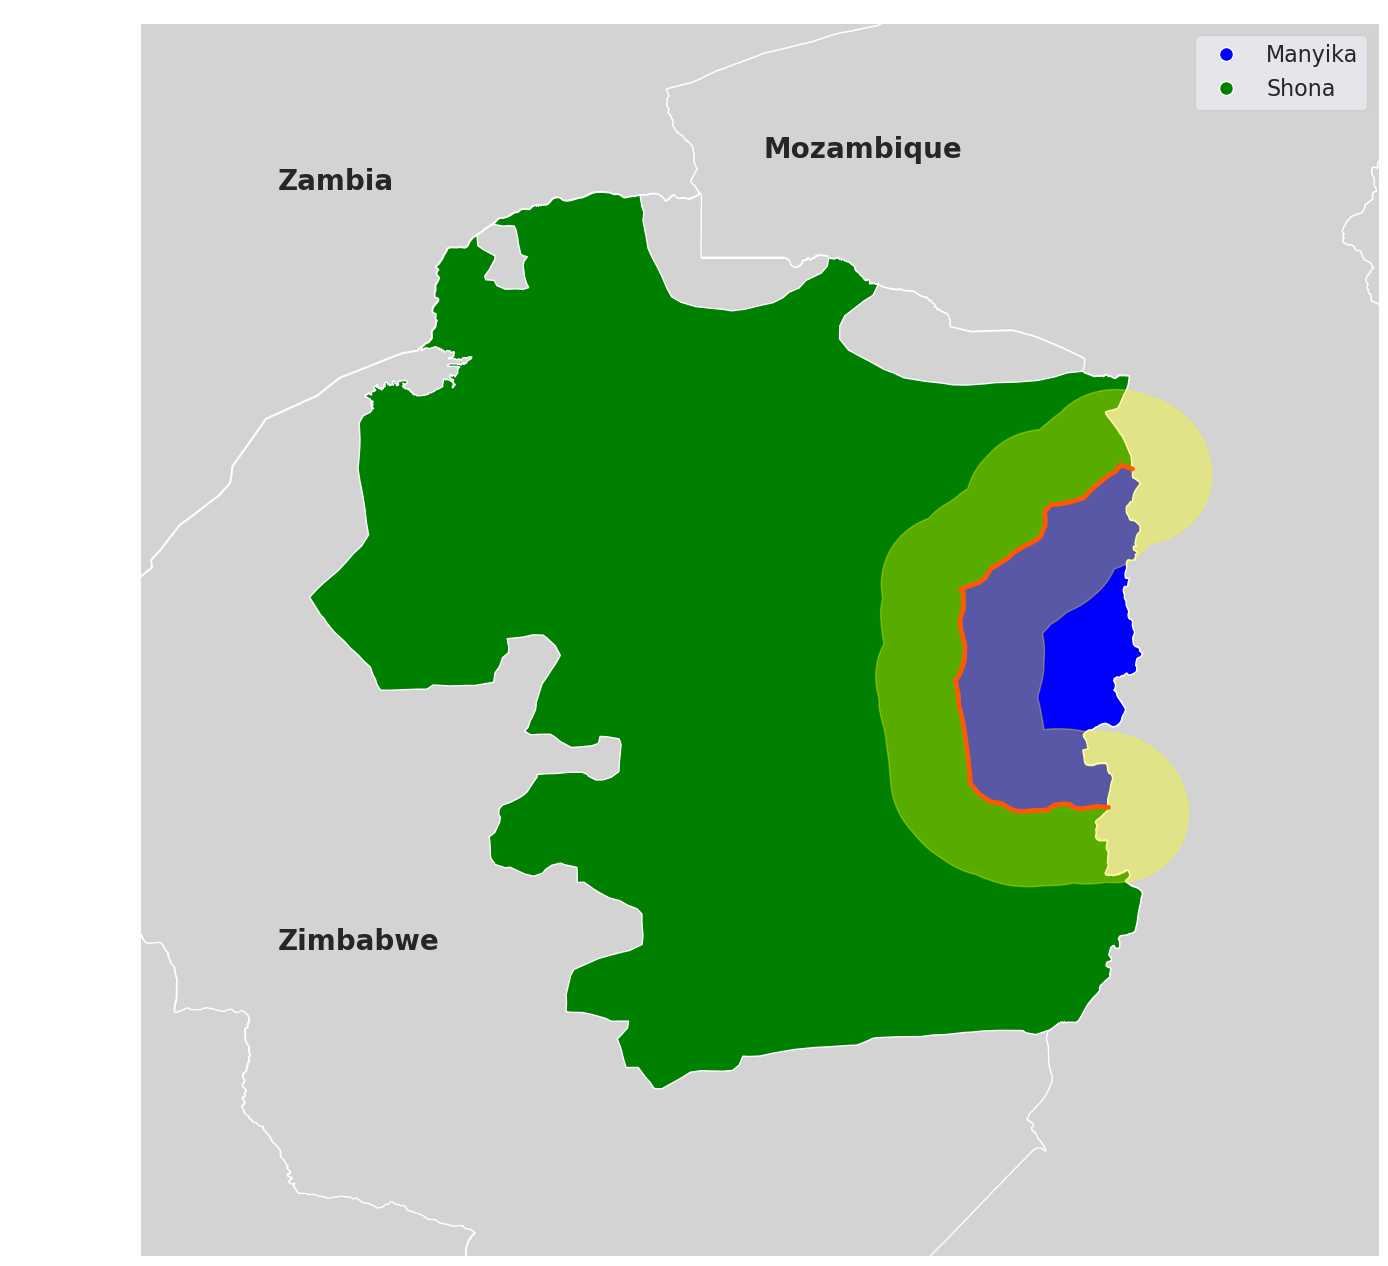

In [25]:
cmap = mpl.colors.ListedColormap(['blue', 'green'])
ax = gplt.choropleth(
        ethn_or, hue='NAM_LABEL', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', linewidth=1,
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap,
        figsize=(24, 16),
        #ax=ax,
        rasterized=True,
    )
gplt.choropleth(
        border_or_wgs84_buf, hue='NAM_LABEL', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='red', linewidth=1,
        #legend=True,
        color='red', alpha=1,
        #figsize=(24, 16),
        ax=ax,
        extent=extent,
    )
gplt.choropleth(
        buffer_or_wgs84, hue='NAM_LABEL', projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='yellow', linewidth=1,
        #legend=True,
        color='yellow', alpha=0.35,
        ax=ax
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
#plt.savefig(pathgraphs + 'figure-1-original-data.pdf', dpi=300, bbox_inches='tight')

<div class="alert alert-block alert-info", >
    <center><H1>Main Replication</H1>
</div>

<div class="alert alert-block alert-info", >
    <center><H1>New Data</H1>
</div>

# Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
## Import data

In [26]:
ethno = gp.read_file(pathethno + 'langa.shp')
#ethno['key'] = 0
ethno.head()

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,"116,000,000 in Russian Federation (2002 census)",116000000,"Indo-European, Slavic, East",L,Indo-European,INDO-EUROPEAN,Russian Federation,rus,"MULTIPOLYGON (((45.11381 43.19151, 45.06952 43..."
1,ENG-USA,eng-USA,eng-us,eng-US,English,English,ENGLISH,English,Americas,United States,"215,000,000 in United States (2000 census)",215000000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,United States,eng,"MULTIPOLYGON (((-75.11965 19.97388, -75.11741 ..."
2,POR-BRA,por-BRA,por-br,por-BR,Portuguese,Portuguese,PORTUGUESE,Portuguese,Americas,Brazil,"163,000,000 in Brazil (1998)",163000000,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Brazil,por,"MULTIPOLYGON (((-52.13058 -31.97901, -52.12447..."
3,ENG-AUS,eng-AUS,eng-au,eng-AS,English,English,ENGLISH,English,Pacific,Australia,"17,400,000 in Australia (2006)",17400000,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,Australia,eng,"MULTIPOLYGON (((147.36099 -43.08758, 147.36375..."
4,CMN-CHN,cmn-CHN,cmn-cn,cmn-CH,Mandarin Chinese,"Chinese, Mandarin","CHINESE, MANDARIN","Chinese, Mandarin",Asia,China,"840,000,000 in China (2000 census)",840000000,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."


In [27]:
ethno = ethno.loc[ethno.LMP_POP1>0].reset_index(drop=True)

In [28]:
ethno.shape

(7327, 19)

# Replicate figure with new data

In [29]:
shona = ethno.loc[(ethno['NAM_LABEL']=='Shona') & (ethno['ID']=='SNA-ZWE')].reset_index()
shona

,index,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
0,87,SNA-ZWE,sna-ZWE,sna-zw,sna-ZI,Shona,Shona,SHONA,Shona,Africa,Zimbabwe,"10,700,000 in Zimbabwe",10700000,"Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...",L,Niger-Congo,NIGER-CONGO,Zimbabwe,sna,"POLYGON ((29.90175 -15.62221, 29.90864 -15.623..."


In [30]:
manyika = ethno.loc[(ethno['NAM_LABEL']=='Manyika') & (ethno['ID']=='MXC-ZWE')].reset_index()
manyika

,index,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry
0,671,MXC-ZWE,mxc-ZWE,mxc-zw,mxc-ZI,Manyika,Manyika,MANYIKA,Manyika,Africa,Zimbabwe,"861,000 in Zimbabwe (2000 WCD)",861000,"Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...",L,Niger-Congo,NIGER-CONGO,Zimbabwe,mxc,"POLYGON ((32.99626 -17.25993, 32.99637 -17.265..."


In [31]:
border =  Borders(manyika, shona)
border

/tmp/ipykernel_2042158/4057681547.py:7: FutureWarning: The `query_bulk()` method is deprecated and will be removed in GeoPandas 1.0. You can use the `query()` method instead.
  idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)


,__idx1,__idx2,index_1,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,...,C1_2,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,geometry
0,0,0,671,MXC-ZWE,mxc-ZWE,mxc-zw,mxc-ZI,Manyika,Manyika,MANYIKA,...,Zimbabwe,"10,700,000 in Zimbabwe",10700000,"Niger-Congo, Atlantic-Congo, Volta-Congo, Benu...",L,Niger-Congo,NIGER-CONGO,Zimbabwe,sna,"MULTILINESTRING ((32.85262 -19.27872, 32.78211..."


In [32]:
buffer = border.copy()
buffer = buffer.to_crs(cea)
buffer.geometry = buffer.geometry.buffer(50000)
buffer = buffer.to_crs(wgs84)
border.geometry = border.geometry.buffer(0.01)

/tmp/ipykernel_2042158/860725491.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  border.geometry = border.geometry.buffer(0.01)


In [33]:
buffer['NAM_LABEL'] = 'Buffer zone (100 km)'
border['NAM_LABEL'] = 'Shona-Mankiya Border'

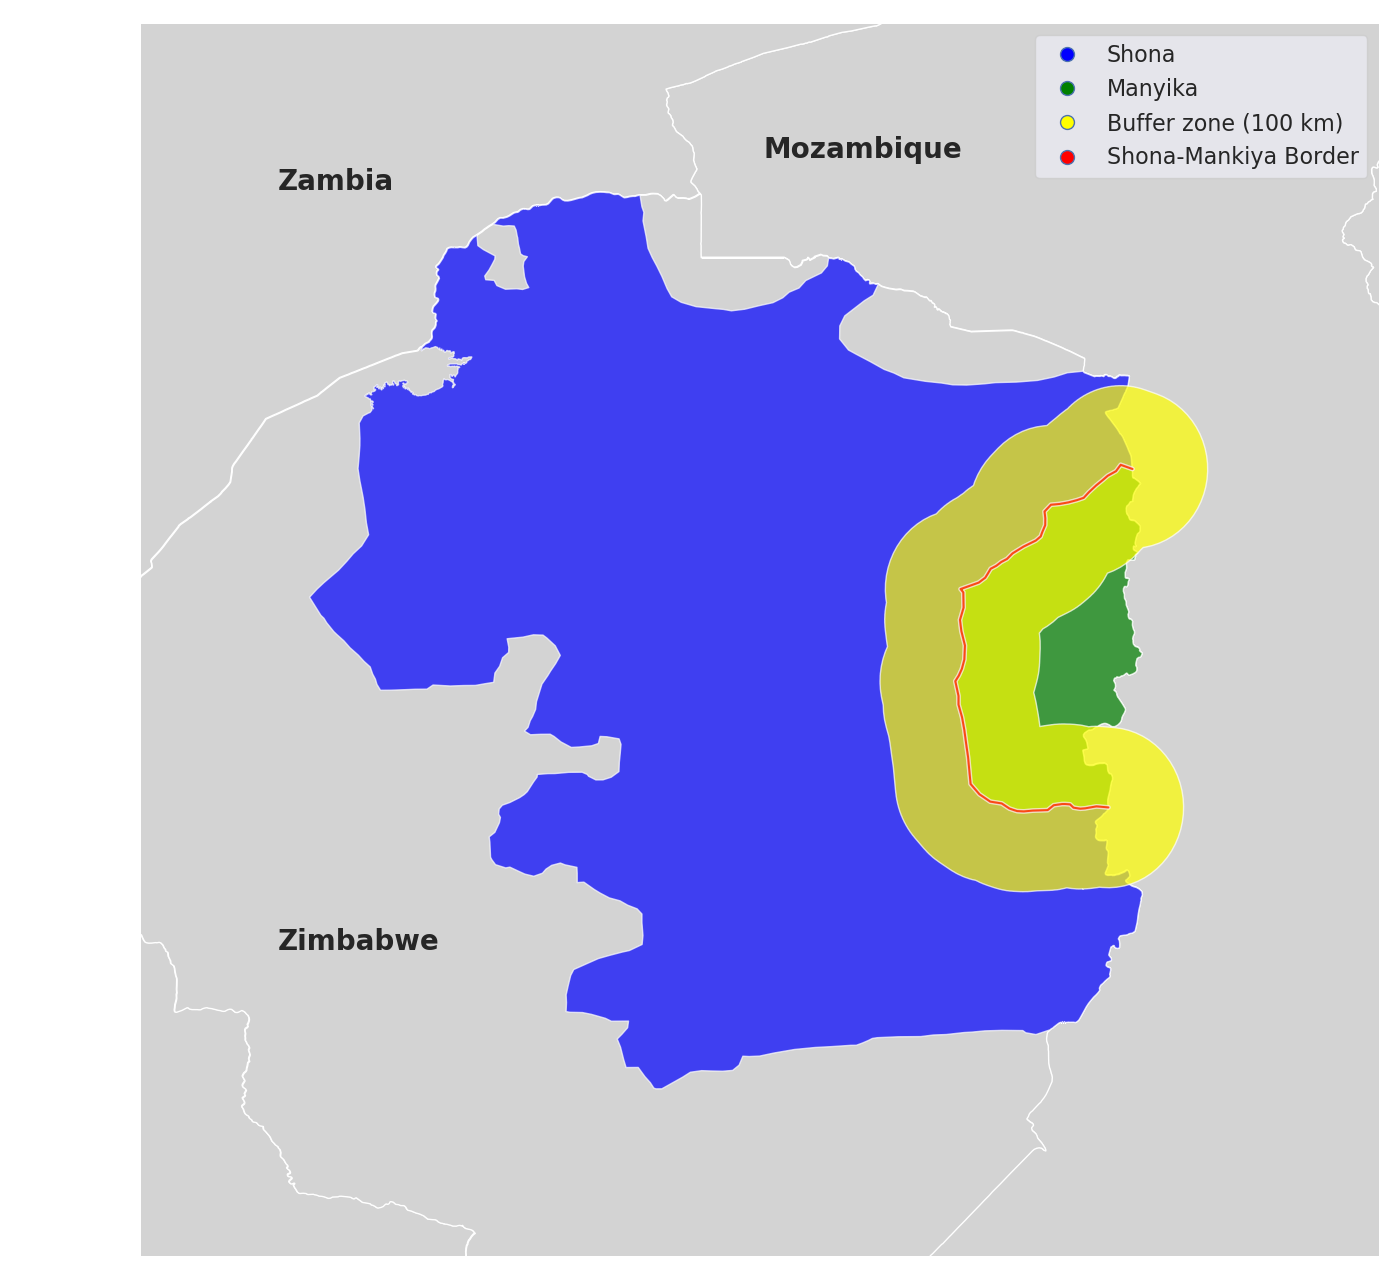

In [34]:
cmap = mpl.colors.ListedColormap(['blue', 'green', 'yellow', 'red'])
dfmap = pd.concat([shona, manyika, buffer, border]).reset_index()

# Retrieve unique labels
labels = dfmap['NAM_LABEL'].unique()

# Create categorical data type
from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=labels, ordered=True)

# Convert 'NAM_LABEL' column to categorical
dfmap['NAM_LABEL_fac'] = dfmap['NAM_LABEL'].astype(cat_type).cat.codes

ax = gplt.choropleth(
        dfmap, hue='NAM_LABEL_fac',
        projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor=None, linewidth=1, 
        legend=True,
        legend_kwargs={'fontsize':16},
        cmap=cmap,
        figsize=(24, 16),
        scheme = mc.UserDefined(dfmap['NAM_LABEL_fac'], bins=dfmap['NAM_LABEL_fac'].tolist()),
        legend_labels=dfmap['NAM_LABEL'].tolist(),
        rasterized=True,
        alpha=0.7#[[0.5, 1, 1, 1]]
    )
gplt.polyplot(
        africa_or, projection=gcrs.PlateCarree(central_longitude=0.0, globe=None),
        edgecolor='white', facecolor='lightgray',
        ax=ax,
        extent=extent,
    )
plt.annotate(text='Zimbabwe', xy=[0.2, 0.25], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Zambia', xy=[0.2, 0.85], xycoords='subfigure fraction', size=20, weight='bold')
plt.annotate(text='Mozambique', xy=[0.55, 0.875], xycoords='subfigure fraction', size=20, weight='bold')
plt.savefig(pathgraphs + 'figure-1-updated-data.pdf', dpi=300, bbox_inches='tight')

# Create borders and buffers using full dataset from Ethnologue 16 edition (paper uses version 16)

# Find duplicated languages x country
## Is this what Dickens calls the groups occupy non-adjacent regions of a country (fn7)?

In [35]:
ethno.loc[ethno.duplicated('ID')]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,geometry


## Create all pairs of languages/countries

In [36]:
import multiprocessing
nb_cpus = multiprocessing.cpu_count()

import dask.dataframe as dd
from dask.distributed import Client, progress, LocalCluster
client = Client(processes=True,threads_per_worker=1, n_workers=nb_cpus,memory_limit='64G')

# Create a Dask client to utilize multiple cores
client = Client()

/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37411 instead
  warnings.warn(
/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41131 instead
  warnings.warn(


In [37]:
ddethno = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno2 = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno['geometry'] = ddethno['geometry'].buffer(0.2)

/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/dask/dataframe/core.py:7175: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


In [38]:
pairs = ddethno.sjoin(ddethno2, predicate="intersects").compute()

/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 67.10 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 10.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 10.0.1 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.

In [39]:
pairs.shape

(74396, 38)

In [40]:
pairs.columns = [c.replace('_left', '_1').replace('_right', '_2') for c in pairs.columns]

In [41]:
pairs.loc[(pairs.ID_1=='MVE-PAK')&(pairs.ID_2=='RWR-IND')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,CNT_2,C1_2,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2
427,MVE-PAK,mve-PAK,mve-pk,mve-PK,Marwari,Marwari,MARWARI,Marwari,Asia,Pakistan,...,Asia,India,"5,600,000 in India (2007 SIL)",5600000,"Indo-European, Indo-Iranian, Indo-Aryan, Centr...",L,Indo-European,INDO-EUROPEAN,India,rwr


In [42]:
pairs = pairs.merge(ethno[['ID', 'geometry']], how='left', left_on='ID_2', right_on='ID', suffixes=['_1', "_2"])
pairs[['ID_1', 'ID_2', 'ID', 'geometry_1', 'geometry_2']].head()

,ID_1,ID_2,ID,geometry_1,geometry_2
0,RUS-RUS,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
1,JPN-JPN,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((153.81556 24.15803, 153.80374 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
2,RUS-RUS,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."
3,CMN-CHN,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((80.58287 38.16474, 80.57683 38...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."
4,KHK-MNG,CMN-CHN,CMN-CHN,"POLYGON ((92.34331 48.19710, 92.35761 48.20942...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ..."


In [43]:
%time
pairs = pairs.loc[pairs['ID_1']!=pairs['ID_2']].reset_index(drop=True)
pairs.shape

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 18.8 µs


(67069, 40)

In [44]:
pairs[['ID_1', 'ID_2', 'NAME2_1', 'NAME2_2']].head()

,ID_1,ID_2,NAME2_1,NAME2_2
0,RUS-RUS,JPN-JPN,RUSSIAN,JAPANESE
1,RUS-RUS,CMN-CHN,RUSSIAN,"CHINESE, MANDARIN"
2,KHK-MNG,CMN-CHN,"MONGOLIAN, HALH","CHINESE, MANDARIN"
3,MVF-CHN,CMN-CHN,"MONGOLIAN, PERIPHERAL","CHINESE, MANDARIN"
4,KHG-CHN,CMN-CHN,"TIBETAN, KHAMS","CHINESE, MANDARIN"


## We have dropped all same pair language/countries, now let's identify all same language pairs that are in differenct countries
## e.g., SPA-MEX and SPA-GTM
## special case MVE-PAK and RWR-IND are the same language (NAME2) even though they have different ISO codes
## Not clear there is a reason for different ISO code, so we also drop them
### (see https://wikitongues.org/languages/mve/, https://wikitongues.org/languages/rwr/, https://www.ethnologue.com/language/rwr/, https://www.ethnologue.com/language/mve/)

## This differs from Dickens, he seems to keep these

In [45]:
pairs.loc[(pairs['ID_1']=='SPA-MEX')& (pairs['ID_2']=='SPA-GTM')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_2
419,SPA-MEX,spa-MEX,spa-mx,spa-MX,Spanish,Spanish,SPANISH,Spanish,Americas,Mexico,...,"4,670,000 in Guatemala (1995)",4670000,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Guatemala,spa,SPA-GTM,"MULTIPOLYGON (((-91.24195 15.43928, -91.21367 ..."


In [46]:
# pairs = pairs.loc[pairs['NAME2_1']!=pairs['NAME2_2']].reset_index(drop=True)
# pairs = pairs.loc[(pairs['ID_1']!='ALN-SRB') & (pairs['ID_2']!='ALN-SRB')].reset_index(drop=True)

# ADD A VARIABLE TO IDENTIFY THESE, DO NOT DROP THEM FROM THE DATASET
pairs["same_lang"] = (pairs['NAME2_1']==pairs['NAME2_2']).astype(int)

pairs.shape

(67069, 41)

In [47]:
pairs[['ID_1','ID_2']].to_stata(proot + 'or_before_non_repeated.dta', version=117)

In [48]:
%time
non_repeated_pairs = drop_repeated(pairs, ['ID_1', 'ID_2'])

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 17.9 µs


In [49]:
non_repeated_pairs

,ID_1,ID_2
0,RUS-RUS,JPN-JPN
1,RUS-RUS,CMN-CHN
2,KHK-MNG,CMN-CHN
3,MVF-CHN,CMN-CHN
4,KHG-CHN,CMN-CHN
...,...,...
36544,SBH-PNG,LIB-PNG
36545,DJE-BFA,HAU-BFA
36546,BHE-PAK,AEQ-PAK
36547,XNB-TWN,SXR-TWN


In [50]:
non_repeated_pairs.to_stata(proot + 'or_after_non_repeated.dta', version=117)

## Somehow the alt buffer and original buffers have different numbers, so let's see what is happening by exporting both pairs and non_repeated pairs

In [51]:
#%%timeit
a = pairs.loc[(pairs['ID_1']=='SPA-CHL') & (pairs['ID_2']=='ARN-ARG')].reset_index()
#a = pairs.loc[(pairs['ID_1']=='KHK-MNG') & (pairs['ID_2']=='CMN-CHN')].reset_index()
#a = pairs.loc[(pairs['ID_1']=='RUS-RUS') & (pairs['ID_2']=='JPN-JPN')].reset_index()
a.apply(lambda x: x.geometry_1.intersection(x.geometry_2.boundary), axis=1)

0    MULTILINESTRING ((-71.55537903410654 -43.09396...
dtype: object

In [52]:
%%time
a.apply(lambda x: x.geometry_1.intersection(x.geometry_2.boundary), axis=1)

CPU times: user 2.57 ms, sys: 266 µs, total: 2.84 ms
Wall time: 2.15 ms


0    MULTILINESTRING ((-71.55537903410654 -43.09396...
dtype: object

In [53]:
%%time
a.apply(lambda x: x.geometry_1.buffer(0.01).intersection(x.geometry_2.boundary), axis=1)

CPU times: user 11.9 ms, sys: 1.94 ms, total: 13.8 ms
Wall time: 8.68 ms


0    MULTILINESTRING ((-71.54585451036695 -43.09087...
dtype: object

In [54]:
a.apply(lambda x: x.geometry_1.buffer(0.01).intersection(x.geometry_2.boundary), axis=1)

0    MULTILINESTRING ((-71.54585451036695 -43.09087...
dtype: object

In [55]:
ddpairs = dask_geopandas.from_geopandas(pairs, npartitions=80)

In [56]:
ddpairs

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,POP_1,LMP_POP1_1,G_1,LMP_CLASS_1,FAMILYPROP_1,FAMILY_1,LMP_C1_1,LANG_ISO_1,geometry_1,index_2,ID_2,ID_ISO_A3_2,ID_ISO_A2_2,ID_FIPS_2,NAM_LABEL_2,NAME_PROP_2,NAME2_2,NAM_ANSI_2,CNT_2,C1_2,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_2,same_lang
npartitions=80,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,object,object,object,object,object,object,object,object,object,object,object,int64,object,object,object,object,object,object,geometry,int64,object,object,object,object,object,object,object,object,object,object,object,int64,object,object,object,object,object,object,object,geometry,int64
839,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66231,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67068,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [57]:
%%time
ddpairs['border'] = ddpairs.apply(lambda x: x.geometry_1.intersection(x.geometry_2.boundary), axis=1, meta=(None, 'geometry'))
#borders = ddpairs.compute(scheduler="threads", num_workers=120)
borders = ddpairs.compute()

/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 1.64 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 31.2 s, sys: 10.1 s, total: 41.3 s
Wall time: 49 s


In [58]:
borders[['ID_1', 'ID_2', 'geometry_1', 'geometry_2', 'border']]

,ID_1,ID_2,geometry_1,geometry_2,border
0,RUS-RUS,JPN-JPN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...",MULTILINESTRING ((145.26184710393858 43.613034...
1,RUS-RUS,CMN-CHN,"MULTIPOLYGON (((179.63528 65.96453, 179.62939 ...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",MULTILINESTRING ((118.04027338250799 49.386957...
2,KHK-MNG,CMN-CHN,"POLYGON ((92.34331 48.19710, 92.35761 48.20942...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",LINESTRING (96.2969147770595 42.52898063260273...
3,MVF-CHN,CMN-CHN,"POLYGON ((97.30358 41.93900, 97.29472 41.94927...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",MULTILINESTRING ((97.17575743470472 42.7728038...
4,KHG-CHN,CMN-CHN,"POLYGON ((86.24880 31.02358, 86.25015 31.02981...","MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",LINESTRING (102.24263019084742 29.725476550719...
...,...,...,...,...,...
67064,HAU-BFA,DJE-BFA,"MULTIPOLYGON (((1.54296 11.82437, 1.54271 11.8...","MULTIPOLYGON (((1.58616 12.54497, 1.58497 12.5...",LINESTRING (1.913310000000024 11.5942549999999...
67065,BHE-PAK,AEQ-PAK,"POLYGON ((69.46580 25.47820, 69.46580 25.47827...","POLYGON ((69.54476 25.17083, 69.54605 25.17116...",LINESTRING (69.54476271484373 25.1708347050781...
67066,AEQ-PAK,BHE-PAK,"POLYGON ((69.40962 25.31827, 69.42491 25.33095...","POLYGON ((69.48241 25.27896, 69.48404 25.27909...",LINESTRING (69.48240614843752 25.2789589296875...
67067,XNB-TWN,SXR-TWN,"POLYGON ((120.87169 23.52521, 120.88809 23.525...","POLYGON ((120.71130 23.26549, 120.71258 23.264...",LINESTRING (120.71130100000005 23.265488000000...


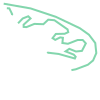

In [59]:
borders.loc[0, 'border']

In [60]:
borders_geo = gp.GeoDataFrame(borders, crs=ethno.crs, geometry='border')
borders_geo.head()

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,ID,geometry_2,same_lang,border
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,Japonic,L,Japonic,JAPONIC,Japan,jpn,JPN-JPN,"MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...",0,"MULTILINESTRING ((145.26185 43.61303, 145.2890..."
1,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",0,"MULTILINESTRING ((118.04027 49.38696, 118.0152..."
2,KHK-MNG,khk-MNG,khk-mn,khk-MG,Halh Mongolian,"Mongolian, Halh","MONGOLIAN, HALH","Mongolian, Halh",Asia,Mongolia,...,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",0,"LINESTRING (96.29691 42.52898, 96.30858 42.544..."
3,MVF-CHN,mvf-CHN,mvf-cn,mvf-CH,Peripheral Mongolian,"Mongolian, Peripheral","MONGOLIAN, PERIPHERAL","Mongolian, Peripheral",Asia,China,...,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",0,"MULTILINESTRING ((97.17576 42.77280, 97.20853 ..."
4,KHG-CHN,khg-CHN,khg-cn,khg-CH,Khams Tibetan,"Tibetan, Khams","TIBETAN, KHAMS","Tibetan, Khams",Asia,China,...,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,CMN-CHN,"MULTIPOLYGON (((108.65391 19.06045, 108.63222 ...",0,"LINESTRING (102.24263 29.72548, 102.20450 29.7..."


In [61]:
borders_geo[borders_geo.columns.difference(['geometry_1', 'geometry_2'])].to_file(pathout + 'ethnologue_bordersv16.json', driver="GeoJSON")
#borders_geo.to_csv(pathout + 'ethnologue_bordersv16.csv', encoding='utf8', index=False)

## Let's see overlap between both datasets and ways to merge

## Create alternative IDs since we do not know order

In [62]:
borders_geo['identifier'] = borders_geo['ID_1'] + '-' + borders_geo['ID_2']
borders_geo['identifier']

0        RUS-RUS-JPN-JPN
1        RUS-RUS-CMN-CHN
2        KHK-MNG-CMN-CHN
3        MVF-CHN-CMN-CHN
4        KHG-CHN-CMN-CHN
              ...       
67064    HAU-BFA-DJE-BFA
67065    BHE-PAK-AEQ-PAK
67066    AEQ-PAK-BHE-PAK
67067    XNB-TWN-SXR-TWN
67068    SXR-TWN-XNB-TWN
Name: identifier, Length: 67069, dtype: object

# CHECK HERE TO GET THE IDENTIFIERS TO THE FINAL DATA USING THE IDENTIFIERS AND SAME-LANG!!!!!

In [63]:
borders_geo[['identifier','same_lang']].to_stata(proot + 'same_language_identifiers.dta', version=117)

In [64]:
dfor['ID_1'] = dfor['identifier'].apply(lambda x: x[:7])
dfor['ID_2'] = dfor['identifier'].apply(lambda x: x[8:])
dfor['ID_1alt'] = dfor['ID_2']
dfor['ID_2alt'] = dfor['ID_1']
dfor[['ID_1', 'ID_2', 'ID_1alt', 'ID_2alt', 'identifier']]

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
0,AAA-NGA,EMA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
1,AAA-NGA,OKE-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
2,AAB-NGA,JID-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
3,AAB-NGA,RIN-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
4,AAB-NGA,TDV-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
15598,ZYN-CHN,YUE-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
15599,ZZJ-CHN,CMN-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
15600,ZZJ-CHN,IUM-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
15601,ZZJ-CHN,TYZ-VNM,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


## Non-repeated language-country pairs in original data

In [65]:
dfor.loc[dfor.duplicated('identifier')]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt


In [66]:
dfor.loc[dfor.duplicated(subset=['ID_1', 'ID_2'])]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt


In [67]:
dfor.loc[dfor.duplicated(subset=['ID_1', 'ID_2'])]

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt


## Merge

In [68]:
merge_iden = dfor[['identifier']].merge(borders_geo[['ID_1', 'ID_2', 'identifier']])
merge_iden

,identifier,ID_1,ID_2
0,AAA-NGA-EMA-NGA,AAA-NGA,EMA-NGA
1,AAA-NGA-OKE-NGA,AAA-NGA,OKE-NGA
2,AAB-NGA-JID-NGA,AAB-NGA,JID-NGA
3,AAB-NGA-RIN-NGA,AAB-NGA,RIN-NGA
4,AAB-NGA-TDV-NGA,AAB-NGA,TDV-NGA
...,...,...,...
15598,ZYN-CHN-YUE-CHN,ZYN-CHN,YUE-CHN
15599,ZZJ-CHN-CMN-CHN,ZZJ-CHN,CMN-CHN
15600,ZZJ-CHN-IUM-CHN,ZZJ-CHN,IUM-CHN
15601,ZZJ-CHN-TYZ-VNM,ZZJ-CHN,TYZ-VNM


In [69]:
merge1 = dfor[['ID_1', 'ID_2', 'ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']])
merge1alt = dfor[['ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']], 
                                                             left_on=['ID_1alt', 'ID_2alt'], right_on=['ID_1', 'ID_2'])
merged1 = pd.concat([merge1, merge1alt]).reset_index(drop=True)
merged1

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
0,AAA-NGA,EMA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
1,AAA-NGA,OKE-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
2,AAB-NGA,JID-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
3,AAB-NGA,RIN-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
4,AAB-NGA,TDV-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
31201,YUE-CHN,ZYN-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
31202,CMN-CHN,ZZJ-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
31203,IUM-CHN,ZZJ-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
31204,TYZ-VNM,ZZJ-CHN,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


In [70]:
merged1.loc[merged1.duplicated(subset=['identifier'])]

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
15603,EMA-NGA,AAA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
15604,OKE-NGA,AAA-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
15605,JID-NGA,AAB-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
15606,RIN-NGA,AAB-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
15607,TDV-NGA,AAB-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
31201,YUE-CHN,ZYN-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
31202,CMN-CHN,ZZJ-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
31203,IUM-CHN,ZZJ-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
31204,TYZ-VNM,ZZJ-CHN,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


In [71]:
dfor[['ID_1', 'ID_2', 'ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']], how='left')

,ID_1,ID_2,ID_1alt,ID_2alt,identifier
0,AAA-NGA,EMA-NGA,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA
1,AAA-NGA,OKE-NGA,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA
2,AAB-NGA,JID-NGA,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA
3,AAB-NGA,RIN-NGA,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA
4,AAB-NGA,TDV-NGA,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA
...,...,...,...,...,...
15598,ZYN-CHN,YUE-CHN,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN
15599,ZZJ-CHN,CMN-CHN,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN
15600,ZZJ-CHN,IUM-CHN,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN
15601,ZZJ-CHN,TYZ-VNM,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM


In [72]:
dfor[['ID_1', 'ID_2', 'identifier']].merge(non_repeated_pairs[['ID_1', 'ID_2']])

,ID_1,ID_2,identifier
0,AAC-PNG,GGW-PNG,AAC-PNG-GGW-PNG
1,AAI-PNG,MBQ-PNG,AAI-PNG-MBQ-PNG
2,AAL-CMR,MXF-CMR,AAL-CMR-MXF-CMR
3,AAL-NGA,KOT-CMR,AAL-NGA-KOT-CMR
4,AAR-ETH,AMH-ETH,AAR-ETH-AMH-ETH
...,...,...,...
2651,ZYB-CHN,ZYN-CHN,ZYB-CHN-ZYN-CHN
2652,ZYB-CHN,ZZJ-CHN,ZYB-CHN-ZZJ-CHN
2653,ZYN-CHN,IUM-CHN,ZYN-CHN-IUM-CHN
2654,ZZJ-CHN,IUM-CHN,ZZJ-CHN-IUM-CHN


In [73]:
dfor[['ID_1alt', 'ID_2alt', 'identifier']].merge(borders_geo[['ID_1', 'ID_2']], left_on=['ID_1alt', 'ID_2alt'], right_on=['ID_1', 'ID_2'])

,ID_1alt,ID_2alt,identifier,ID_1,ID_2
0,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA,EMA-NGA,AAA-NGA
1,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA,OKE-NGA,AAA-NGA
2,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA,JID-NGA,AAB-NGA
3,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA,RIN-NGA,AAB-NGA
4,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA,TDV-NGA,AAB-NGA
...,...,...,...,...,...
15598,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN,YUE-CHN,ZYN-CHN
15599,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN,CMN-CHN,ZZJ-CHN
15600,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN,IUM-CHN,ZZJ-CHN
15601,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM,TYZ-VNM,ZZJ-CHN


In [74]:
dfor[['ID_1alt', 'ID_2alt', 'identifier']].merge(non_repeated_pairs[['ID_1', 'ID_2']], left_on=['ID_1alt', 'ID_2alt'], right_on=['ID_1', 'ID_2'])

,ID_1alt,ID_2alt,identifier,ID_1,ID_2
0,EMA-NGA,AAA-NGA,AAA-NGA-EMA-NGA,EMA-NGA,AAA-NGA
1,OKE-NGA,AAA-NGA,AAA-NGA-OKE-NGA,OKE-NGA,AAA-NGA
2,JID-NGA,AAB-NGA,AAB-NGA-JID-NGA,JID-NGA,AAB-NGA
3,RIN-NGA,AAB-NGA,AAB-NGA-RIN-NGA,RIN-NGA,AAB-NGA
4,TDV-NGA,AAB-NGA,AAB-NGA-TDV-NGA,TDV-NGA,AAB-NGA
...,...,...,...,...,...
14365,YUE-CHN,ZYN-CHN,ZYN-CHN-YUE-CHN,YUE-CHN,ZYN-CHN
14366,CMN-CHN,ZZJ-CHN,ZZJ-CHN-CMN-CHN,CMN-CHN,ZZJ-CHN
14367,IUM-CHN,ZZJ-CHN,ZZJ-CHN-IUM-CHN,IUM-CHN,ZZJ-CHN
14368,TYZ-VNM,ZZJ-CHN,ZZJ-CHN-TYZ-VNM,TYZ-VNM,ZZJ-CHN


In [75]:
%%time
non_repeated_pairs_or = drop_repeated(dfor[['ID_1', 'ID_2', 'identifier']], ['ID_1', 'ID_2'])
non_repeated_pairs_or

CPU times: user 4.58 s, sys: 161 ms, total: 4.74 s
Wall time: 5.22 s


,ID_1,ID_2
0,AAA-NGA,EMA-NGA
1,AAA-NGA,OKE-NGA
2,AAB-NGA,JID-NGA
3,AAB-NGA,RIN-NGA
4,AAB-NGA,TDV-NGA
...,...,...
15598,ZYN-CHN,YUE-CHN
15599,ZZJ-CHN,CMN-CHN
15600,ZZJ-CHN,IUM-CHN
15601,ZZJ-CHN,TYZ-VNM


# We have (essencially) replicated his data

<div class="alert alert-block alert-info", >
    <center><H1>New Data - Buffers</H1>
</div>

In [76]:
# buffers= borders_geo[['identifier', 'border']].merge(merge_iden[['identifier']])
buffers= borders_geo[['identifier', 'border']]
buffers

,identifier,border
0,RUS-RUS-JPN-JPN,"MULTILINESTRING ((145.26185 43.61303, 145.2890..."
1,RUS-RUS-CMN-CHN,"MULTILINESTRING ((118.04027 49.38696, 118.0152..."
2,KHK-MNG-CMN-CHN,"LINESTRING (96.29691 42.52898, 96.30858 42.544..."
3,MVF-CHN-CMN-CHN,"MULTILINESTRING ((97.17576 42.77280, 97.20853 ..."
4,KHG-CHN-CMN-CHN,"LINESTRING (102.24263 29.72548, 102.20450 29.7..."
...,...,...
67064,HAU-BFA-DJE-BFA,"LINESTRING (1.91331 11.59425, 1.91224 11.59416..."
67065,BHE-PAK-AEQ-PAK,"LINESTRING (69.54476 25.17083, 69.54605 25.171..."
67066,AEQ-PAK-BHE-PAK,"LINESTRING (69.48241 25.27896, 69.48404 25.279..."
67067,XNB-TWN-SXR-TWN,"LINESTRING (120.71130 23.26549, 120.71258 23.2..."


In [77]:
buffers.to_file(pathout + 'Dickens_ethnologue_bordersv16.json', driver="GeoJSON")

## We convert to CEA to construct the buffers and create the data

In [78]:
buffers = gp.read_file(pathout + 'Dickens_ethnologue_bordersv16.json', driver="GeoJSON")

In [79]:
buffers = buffers.to_crs(cea)

In [80]:
buffers.loc[buffers.identifier.isin(dfor.loc[(dfor.overlap==1)&(dfor.lingDist.isna()==False), 'identifier'])]

,identifier,geometry
2,KHK-MNG-CMN-CHN,"LINESTRING (10719723.518 4291279.974, 10721022..."
4,KHG-CHN-CMN-CHN,"LINESTRING (11381597.530 3144847.052, 11377352..."
7,ADX-CHN-CMN-CHN,"MULTILINESTRING ((11504121.326 3400425.288, 11..."
8,XAL-CHN-CMN-CHN,"MULTILINESTRING ((11246691.544 3767434.038, 11..."
9,KAZ-CHN-CMN-CHN,"MULTILINESTRING ((9550142.527 4339640.290, 954..."
...,...,...
64892,SPI-IDN-WRP-IDN,"MULTILINESTRING ((15198378.500 -243002.697, 15..."
65282,NFK-NGA-NIN-NGA,"MULTILINESTRING ((946192.295 1014271.323, 9477..."
65283,NFG-NGA-NIN-NGA,"MULTILINESTRING ((946192.295 1014271.323, 9477..."
65779,DTI-MLI-DYM-MLI,"LINESTRING (-358800.975 1596475.771, -358305.1..."


In [81]:
buffers.to_file(pathout + 'Dickens_ethnologue_bordersv16_cyl.json', driver="GeoJSON")

In [82]:
buffers = gp.read_file(pathout + 'Dickens_ethnologue_bordersv16_cyl.json', driver="GeoJSON")

In [83]:
buffers = dask_geopandas.from_geopandas(buffers, npartitions=50)

In [84]:
buffers.shape

(Delayed('int-6bf46500-a61c-4494-adac-290f5ed2f9f5'), 2)

In [85]:
buffers.geometry = buffers.geometry.buffer(buffer_size_radius_km * 1000)
buffers = buffers.compute()

/lustre/work/client/users/gonzalezjj/.conda/envs/ReplicationDickens/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 58.25 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [86]:
buffers.to_file(pathout + 'Dickens_ethnologue_buffersv16_cyl_'+ str(buffer_size_radius_km) +'.json', driver="GeoJSON")

In [87]:
buffers = buffers.to_crs(wgs84)

In [88]:
buffers.to_file(pathout + 'Dickens_ethnologue_buffersv16_'+str(buffer_size_radius_km)+'.json', driver="GeoJSON")

/tmp/ipykernel_2042158/2640991670.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffers.centroid.plot()


<Axes: >

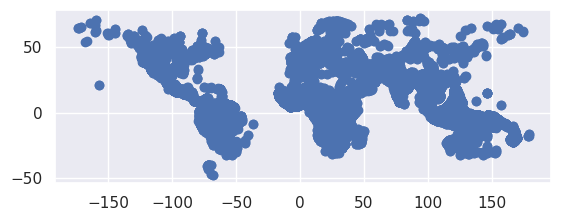

In [89]:
buffers.centroid.plot()

In [90]:
type(buffers)

geopandas.geodataframe.GeoDataFrame

<div class="alert alert-block alert-info", >
    <center><H1>New Data - Spatial Stats for New Buffers</H1>
</div>

In [91]:
buffers = gp.read_file(pathout + 'Dickens_ethnologue_buffersv16_'+str(buffer_size_radius_km)+'.json', driver="GeoJSON")
buffers.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## BZX-MLI is contained inside the homeland of FFM-MLI and is only 290m^2 so we also drop it
## Construction identifies it by assigning empty border

In [92]:
dfor.loc[dfor.identifier=='BZX-MLI-FFM-MLI']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region,ID_1,ID_2,ID_1alt,ID_2alt
2571,BZX-MLI-FFM-MLI,"Bozo, Hainyaxo",bzx,Mali,Niger-Congo,"Fulfulde, Maasina",ffm,Mali,Niger-Congo,0.869855,...,FULFULDE_MAASINA,"Niger-Congo,Mande,Western,Northwestern,Soninke...","Niger-Congo,Atlantic-Congo,Atlantic,Northern,S...",466.0,466.0,Africa,BZX-MLI,FFM-MLI,FFM-MLI,BZX-MLI


In [93]:
buffers.loc[buffers.is_valid==False]

,identifier,geometry
585,SDH-IRN-BGN-IRN,None
1181,RWR-IND-PNB-PAK,"POLYGON ((73.31460 30.25415, 73.33096 30.25520..."
1303,SKG-MDG-PLT-MDG,"POLYGON ((45.52564 -20.10826, 45.50705 -20.086..."
3708,FRA-CAN-MIC-CAN,"MULTIPOLYGON (((-60.26594 45.41216, -60.27905 ..."
6738,XMW-MDG-PLT-MDG,"POLYGON ((47.46021 -15.86305, 47.53486 -15.769..."
14226,WPC-VEN-PID-VEN,None
14594,ANT-AUS-KDD-AUS,None
14643,YAU-VEN-PBH-VEN,None
17599,SBN-PAK-SND-PAK,None
17684,AAO-NER-THZ-NER,None


In [102]:
# buffers = buffers.loc[buffers.identifier!='BZX-MLI-FFM-MLI'].reset_index(drop=True)
buffers = buffers.loc[buffers.is_valid==True].reset_index(drop=True)
buffers

,identifier,geometry
0,RUS-RUS-JPN-JPN,"POLYGON ((144.92739 43.20110, 144.90680 43.234..."
1,RUS-RUS-CMN-CHN,"POLYGON ((117.42973 49.66238, 117.42985 49.663..."
2,KHK-MNG-CMN-CHN,"POLYGON ((95.91796 42.85611, 95.92721 42.88553..."
3,MVF-CHN-CMN-CHN,"MULTIPOLYGON (((115.06758 41.40184, 114.88094 ..."
4,KHG-CHN-CMN-CHN,"POLYGON ((102.62723 29.99294, 102.64320 29.960..."
...,...,...
67020,HAU-BFA-DJE-BFA,"POLYGON ((1.95033 11.13483, 1.90903 11.13318, ..."
67021,BHE-PAK-AEQ-PAK,"POLYGON ((69.25871 25.55570, 69.29239 25.58382..."
67022,AEQ-PAK-BHE-PAK,"MULTIPOLYGON (((69.36353 25.76059, 69.32186 25..."
67023,XNB-TWN-SXR-TWN,"POLYGON ((120.94091 23.68830, 120.97557 23.663..."


# Work with CSI data to compute spatial statistics

In [103]:
CSI = os.listdir(proot + 'CSI')

In [104]:
CSI.remove('ReadMe.txt')
CSI.sort()
CSI

['dif2AverageCalories.tif',
 'dif2AverageCalories0.tif',
 'dif2AverageCaloriesNo0.tif',
 'dif2OptCalories.tif',
 'dif2OptCalories0.tif',
 'dif2OptCaloriesNo0.tif',
 'difAverageCalories.tif',
 'difAverageCalories0.tif',
 'difAverageCaloriesNo0.tif',
 'difOptCalories.tif',
 'difOptCalories0.tif',
 'difOptCaloriesNo0.tif',
 'post1500AverageCalories.tif',
 'post1500AverageCalories0.tif',
 'post1500AverageCaloriesNo0.tif',
 'post1500OptCalories.tif',
 'post1500OptCalories0.tif',
 'post1500OptCaloriesNo0.tif',
 'pre15002AverageCalories.tif',
 'pre15002AverageCalories0.tif',
 'pre15002AverageCaloriesNo0.tif',
 'pre15002OptCalories.tif',
 'pre15002OptCalories0.tif',
 'pre15002OptCaloriesNo0.tif',
 'pre1500AverageCalories.tif',
 'pre1500AverageCalories0.tif',
 'pre1500AverageCaloriesNo0.tif',
 'pre1500OptCalories.tif',
 'pre1500OptCalories0.tif',
 'pre1500OptCaloriesNo0.tif']

In [105]:
%%time
for r in CSI:
    print(r.replace('.tif', ''))
    # Import raster
    csi = gr.from_file(proot + '/CSI/' + r)
    # Compute stats for first section of buffer
    out= csi.stats(buffers, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[1:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier'] + [r.replace('.tif', '') + c for c in out.columns[1:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + '_' + r.replace('.tif', '') + '.dta', version=117, write_index=False)    

dif2AverageCalories
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
dif2AverageCalories0
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
dif2AverageCaloriesNo0
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
dif2OptCalories
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
dif2OptCalories0
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
dif2OptCaloriesNo0
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
difAverageCalories
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
difAverageCalories0
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
difAverageCaloriesNo0
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
difOptCalories
Index(['identifier', 'mean', 'max', 'min', 'median', 'std'], dtype='object')
difOptCalories0
Index(['identifier', '

In [106]:
%%time
out = []
for r in CSI:
    print(r.replace('.tif', ''))
    out1 = pd.read_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + '_' + r.replace('.tif', '') + '.dta')   
    out1 = out1.set_index(['identifier'])
    out.append(out1)

dif2AverageCalories
dif2AverageCalories0
dif2AverageCaloriesNo0
dif2OptCalories
dif2OptCalories0
dif2OptCaloriesNo0
difAverageCalories
difAverageCalories0
difAverageCaloriesNo0
difOptCalories
difOptCalories0
difOptCaloriesNo0
post1500AverageCalories
post1500AverageCalories0
post1500AverageCaloriesNo0
post1500OptCalories
post1500OptCalories0
post1500OptCaloriesNo0
pre15002AverageCalories
pre15002AverageCalories0
pre15002AverageCaloriesNo0
pre15002OptCalories
pre15002OptCalories0
pre15002OptCaloriesNo0
pre1500AverageCalories
pre1500AverageCalories0
pre1500AverageCaloriesNo0
pre1500OptCalories
pre1500OptCalories0
pre1500OptCaloriesNo0
CPU times: user 1.49 s, sys: 597 ms, total: 2.09 s
Wall time: 2.25 s


In [107]:
out = pd.concat(out, axis=1)

In [108]:
out.to_stata(proot + 'Dickens_OrBuf_v16_stats_'+str(buffer_size_radius_km)+'.dta', version=117)

# Work with CSI specific crops

In [ ]:
CSI_crops = os.listdir(proot + 'CSICrops')
CSI_crops.sort()
CSI_crops

In [ ]:
%%time
for r in CSI_crops:
    print(r.replace('.tif', ''))
    # Import raster
    csi = gr.from_file(proot + '/CSICrops/' + r)
    # Compute stats for first section of buffer
    out= csi.stats(buffers, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[1:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier'] + [r.replace('.tif', '') + c for c in out.columns[1:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + '_' + r.replace('.tif', '') + '.dta', version=117, write_index=False) 

In [ ]:
%%time
out = []
for r in CSI_crops:
    print(r.replace('.tif', ''))
    out1 = pd.read_stata(pathstats + 'Dickens_ethnologue_v16_'+ str(buffer_size_radius_km) + '_' + r.replace('.tif', '') + '.dta')   
    out1 = out1.set_index(['identifier'])
    out.append(out1)

In [ ]:
out = pd.concat(out, axis=1)

In [ ]:
out.to_stata(proot + 'Dickens_OrBuf_v16_cropstats_'+str(buffer_size_radius_km)+'.dta', version=117)